# Import Libraries

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.decomposition import PCA
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.calibration import CalibratedClassifierCV

# Loading of the Data

In [2]:
data = pd.read_csv('./data/data.csv')
holdout = pd.read_csv('./data/holdout.csv')
ID = holdout[['ID']].copy().astype(int)
del holdout['ID']
data.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,...,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,...,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,no
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,...,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,no
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,...,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,no
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,...,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,no
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,...,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,no


In [3]:
for f in data.columns:
    if len(set(data[f])) < 20:
        print("{} : {}".format(f, set(data[f])))

job : {'housemaid', 'blue-collar', 'technician', 'unknown', 'retired', 'self-employed', 'unemployed', 'services', 'admin.', 'management', 'student', 'entrepreneur'}
marital_status : {'married', 'divorced', 'unknown', 'single'}
education : {'unknown', 'professional.course', 'basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'illiterate', 'university.degree'}
credit_default : {'no', 'unknown', 'yes'}
housing : {'yes', 'unknown', 'no'}
loan : {'no', 'unknown', 'yes'}
contact : {'cellular', 'telephone'}
month : {'jul', 'nov', 'oct', 'dec', 'jun', 'may', 'aug', 'mar', 'sep', 'apr'}
day_of_week : {'mon', 'thu', 'wed', 'tue', 'fri'}
prev_contacts : {0, 1, 2, 3, 4, 5, 6, 7}
prev_outcomes : {'success', 'failure', 'nonexistent'}
subscribed : {'no', 'yes'}


# Exploration and Preparation

In this step, we look into the data and try to understand it before modeling. .

## Exploration

Plotting Continuous variables against the target, then Categorical Variables

In [4]:
def remove_unwanted_features(X):
    if('duration' in list(X.columns)):
        del X['duration']

We are going to stat by removing the unwanted, irrelevant features.
We are also going to separate the discrete and continuous features that we might have to process differently. Finally, we are going te see the ratio of positive example in the dataset.

In [5]:
features = list(data.keys())#.remove('subscribed')
#print(features)
features.remove('subscribed')
X = data[features]
#remove duration which won't be available
remove_unwanted_features(X)
remove_unwanted_features(holdout)
features = list(X.keys())

y = data['subscribed']
y = y.apply(lambda x: 1 if x == 'yes' else 0)
cat_features = ['contact', 'credit_default', 'day_of_week', 'housing', 'job', 'loan', 'marital_status', 'month'
               , 'prev_outcomes', 'education', 'prev_contacts' ]
continuous_features = list(set(list(X.keys())) - set(cat_features))
y.loc[y == 1].count()/ y.loc[y == 0].count()

0.12695806826732334

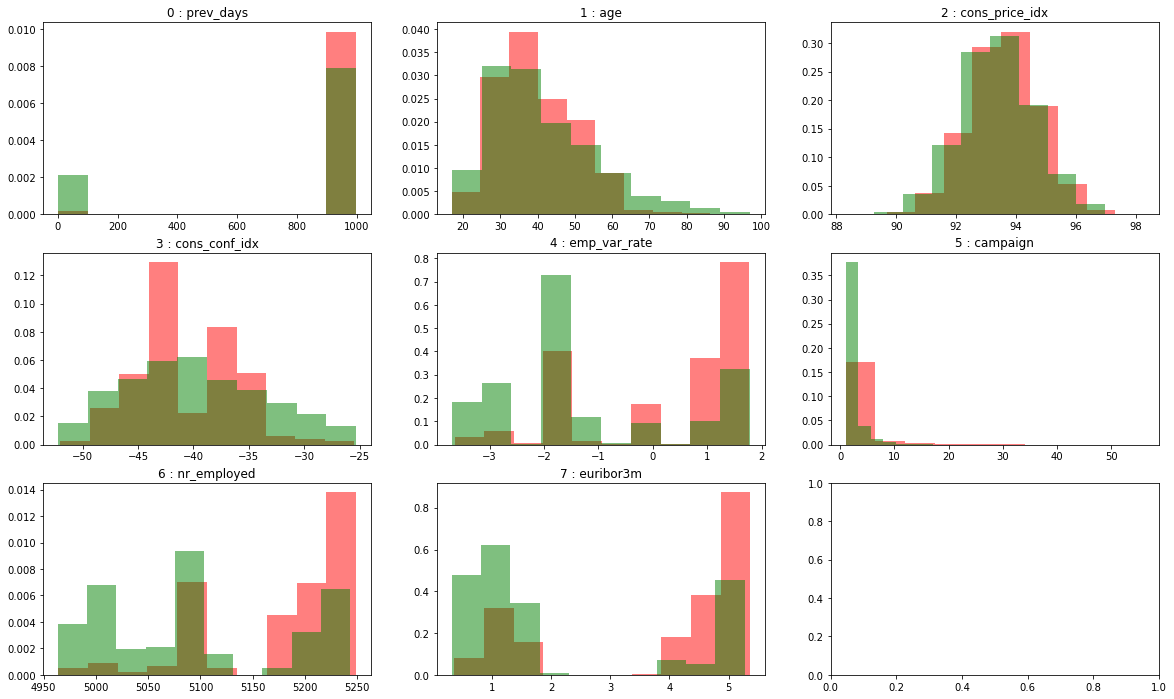

In [6]:
##plotting histograms for the continuous features
f, axarr = plt.subplots(3,3, figsize=(20, 12))
for i in range(len(continuous_features)):
    axarr[i //3, i%3].hist(X[continuous_features[i]][y == 0].dropna(), alpha = .5, color = 'r', normed = 1 )
    axarr[i //3, i%3].hist(X[continuous_features[i]][y == 1].dropna(), alpha = .5, color = 'g', normed = 1 )#
    axarr[i //3, i%3].set_title("{} : {}".format(i, continuous_features[i]))

    
plt.show()

### Encoding categorical 

The categorical features need to encoded using integers instead of string to comply with the scikit learn framework

In [7]:
discrete_features_index = [i for i, j in enumerate(features) if j in cat_features]
def label_encoding(X):
    X_encoded = X.copy()
    for f in cat_features:
        le = LabelEncoder()
        X_encoded[f] = le.fit_transform(X_encoded[f])
    return X_encoded

In [8]:
X = X[cat_features + continuous_features]
X_encoded = label_encoding(X)
X_encoded.columns

Index(['contact', 'credit_default', 'day_of_week', 'housing', 'job', 'loan',
       'marital_status', 'month', 'prev_outcomes', 'education',
       'prev_contacts', 'prev_days', 'age', 'cons_price_idx', 'cons_conf_idx',
       'emp_var_rate', 'campaign', 'nr_employed', 'euribor3m'],
      dtype='object')

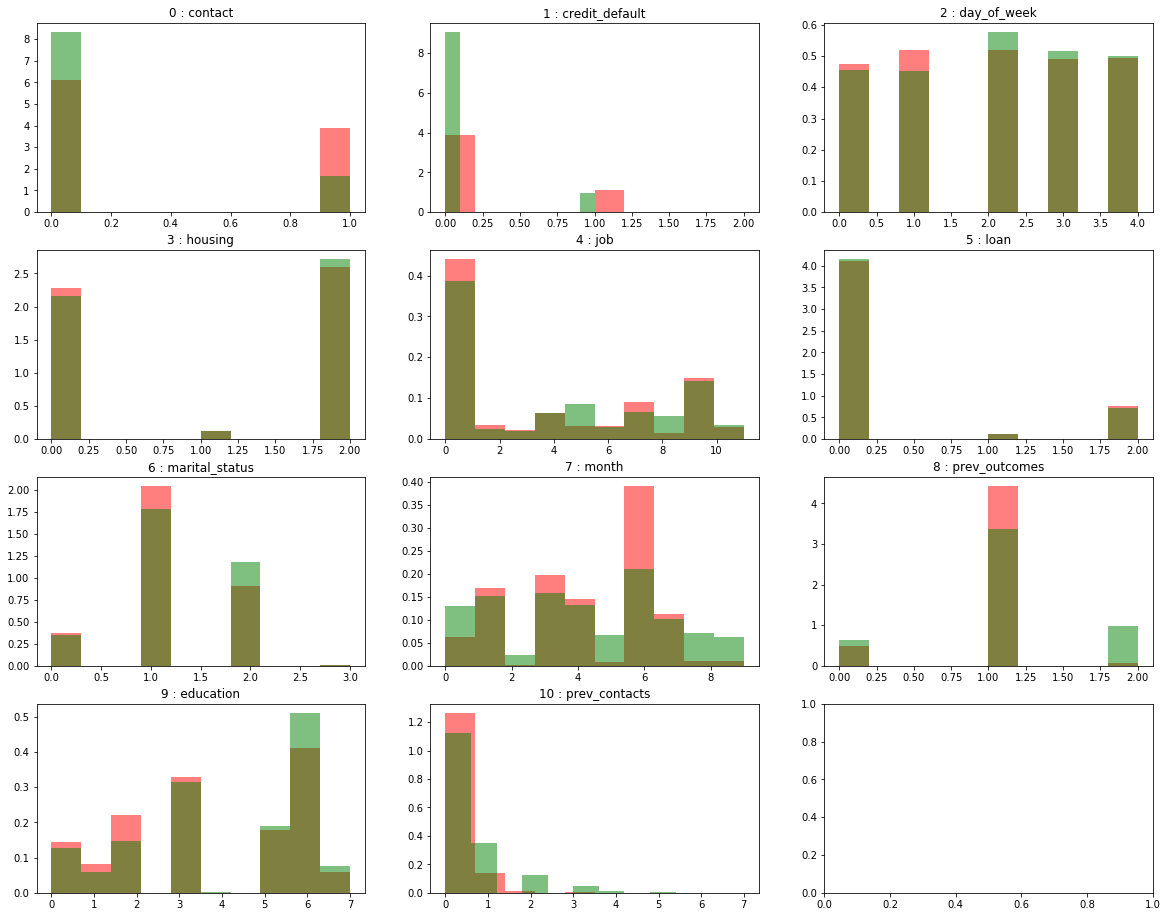

In [9]:
#Plotting the discrete features
f, axarr = plt.subplots(4,3, figsize=(20, 16))
for i in range(len(cat_features)):
    axarr[i //3, i%3].hist(X_encoded[cat_features[i]][y == 0].dropna(), alpha = .5, color = 'r', normed = 1 )
    axarr[i //3, i%3].hist(X_encoded[cat_features[i]][y == 1].dropna(), alpha = .5, color = 'g', normed = 1 )
    axarr[i //3, i%3].set_title("{} : {}".format(i, cat_features[i]))

    
plt.show()

### Dimensionnality Reduction using PCA (use of Count Base encoding to encode Categorical variables)

#### Count-based encoding
We created our own implementation of the count-based encoding which is going to 
replace the differents classes of the features by the proportion of positive example in that class. For the test set, if there is a feature that is not observed the count proportion will just be 0

In [10]:
def count_enc(X_train, X_test, y_train, cat_features):
    X_train_enc = X_train.copy()
    X_test_enc = X_test.copy()
    y_temp = pd.DataFrame(y_train, columns = ['subscribed'])
    data_train = pd.concat([X_train_enc, y_temp], axis=1, join='inner')
    for i in range(len(cat_features)):
        counts = data_train.groupby([cat_features[i]], as_index=False)['subscribed'].mean()
        data_train['{}_enc'.format(cat_features[i])] = data_train[[cat_features[i]]].applymap(lambda x : counts['subscribed'][x] if x in list(counts.index) else 0)

        X_test_enc['{}_enc'.format(cat_features[i])] = X_test_enc[[cat_features[i]]].applymap(lambda x : counts['subscribed'][x] if x in list(counts.index) else 0)

        del data_train[cat_features[i]]
        del X_test_enc[cat_features[i]]
    features_enc = list(data_train.keys())
    features_enc.remove('subscribed')
    X_train_enc = data_train[features_enc]
    X_train_enc.shape, X_test_enc.shape
    
    return X_train_enc, X_test_enc

#### PCA 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, stratify=y)  
X_train_enc, X_test_enc = count_enc(X_train, X_test, y_train, cat_features)
X_plot= pd.DataFrame(PCA(n_components=2).fit_transform(X_train_enc), columns = ['0', '1'])

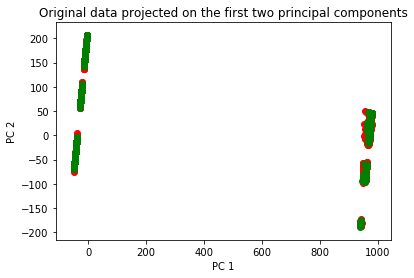

In [12]:
pos = np.array(y.loc[y==1].index.tolist())
neg = np.array(y.loc[y==0].index.tolist())
plt.scatter(X_plot['0'][neg], X_plot['1'][neg], color = 'r')
plt.scatter(X_plot['0'][pos], X_plot['1'][pos], color = 'g')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Original data projected on the first two principal components')
plt.show()

## Preparation

In terms of data preparation, we started by binning the feature 'prev_days' to make it a categorical feature. Indeed, the value 999 wasn't on the same scale as the other values, as it meant 'No previous call'. After realizing that, although it makes more sense like that, it didn't increase our models, we removed it from the preprocessing tasks.

We have basically tried the following preprocessing tasks, then run them on the different models:

1. Count-based encoding

2. OneHot Encoding

3. OneHot Encoding + Feature Selection (top 20 using Mutual Info)

4. OneHot Encoding + Feature Selection (top 13 using Mutual Information / KBest) + Polynomial Expansion

Please note that, when fitting the tree-based models, we didn't encode the data using OneHot or Count Based, but simply encoding the different classes into integers. When fitting ensemble models combining both linear and tree-based models, we had to make all features continuous, using OneHot or Count-based.


Basically, after trying these preprocessing combinations, we realized that the OneHot encoding only was the most efficient. Right after, we looked again at the data and tried the following: Many categorical features had 'unknown' classes: "job, marital_status, education, credit_default, housing, loan". We imputed the values using a model-based imputation with kNN and RandomForest. It actually improved our roc-auc scores.

Eventually, the final preprocessing set up is: 

1. Get rid of the 'duration' feature

2. Encode all categorical features to strings using LabelEncoder

3. Impute categorical features with 'unknown' as a class

4. Encode all categorical features using OneHot encoding

Below is the different functions used while trying all these preprocessing options.

### Transform feature 'prev_days' into bins

In [13]:
def digitize(X):
    data = X.copy()
    data['prev_days_bins'] = data['prev_days'].copy()
    prev_days = data['prev_days']
    bins = [  0.  ,   6.75,  13.5 ,  20.25,  27. , 1000 ] 
    data['prev_days_bins'] = np.digitize(prev_days.values, bins = bins)
    del data['prev_days']
    return data

## Details of the 4th proprecessing task

We encode the dataset. The downside of using this for feature selection is that it is a little bit hard to go back to the features names.

In [14]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
#pipe = Pipeline([('oh', oh)])
X_rdy = pd.DataFrame(oh.fit_transform(X_encoded))

Then compute the Mutual Information

In [15]:
mi = mutual_info_classif(X_rdy, y)
mi_index = [list(mi).index(f) for f in sorted(mi)]
sorted_col = X_rdy.columns[mi_index]


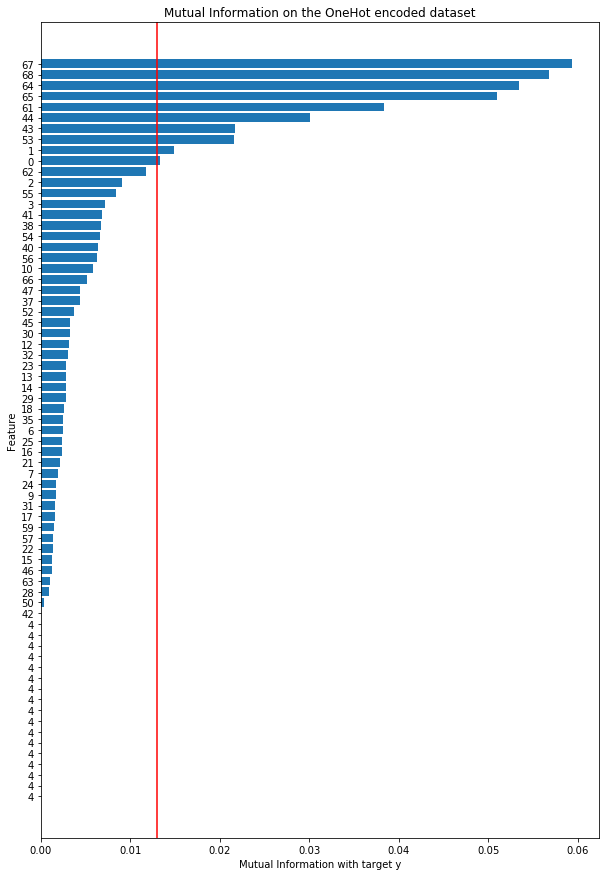

In [16]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(mi)), sorted(mi))
plt.axvline(x=0.013, c='r')
plt.title('Mutual Information on the OneHot encoded dataset')
plt.xlabel('Mutual Information with target y')
plt.ylabel('Feature')
plt.yticks(np.arange(len(mi)), sorted_col);

We only keep features that have a Mutual Information >= 0.013

In [17]:
colnames = X_rdy.columns
for f in range(len(mi)):
    if mi[f] < 0.013:
        del X_rdy[colnames[f]]

Then proceed with the polynomial expansion

In [18]:
poly = PolynomialFeatures(2)
X_poly = pd.DataFrame(poly.fit_transform(X_rdy))

Then re-compute the Mutual Information

In [19]:
mi_poly = mutual_info_classif(X_poly, y)
mi_poly_index = [list(mi_poly).index(f) for f in sorted(mi_poly)]
sorted_col_poly = X_poly.columns[mi_poly_index]

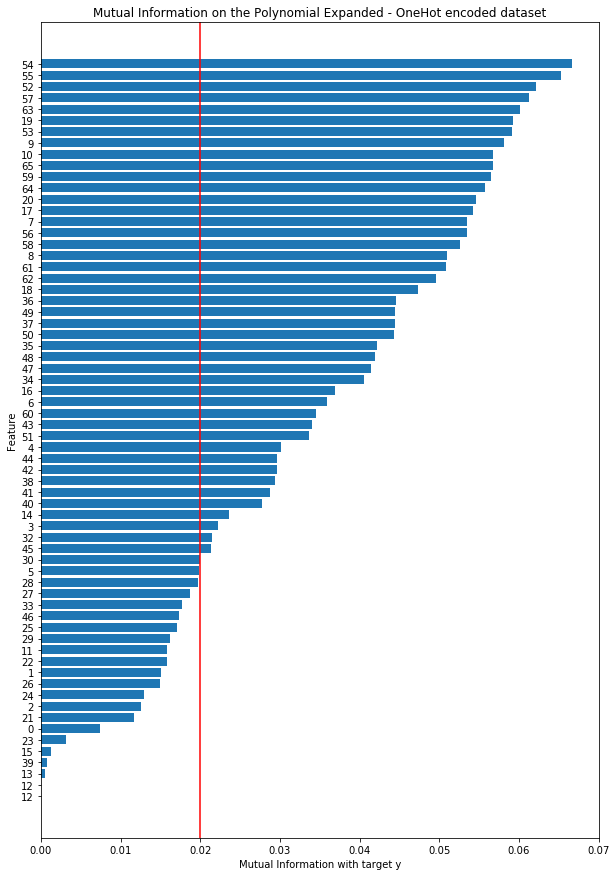

In [20]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(mi_poly)), sorted(mi_poly))
plt.axvline(x=0.02, c='r')
plt.title('Mutual Information on the Polynomial Expanded - OneHot encoded dataset')
plt.xlabel('Mutual Information with target y')
plt.ylabel('Feature')
plt.yticks(np.arange(len(mi_poly)), sorted_col_poly);

When comparing the two graphs, the processed dataset has a higher average mutual information. We thus tend to believe that the features carry more information so as to better predict on y. However, in the end, it didn't improve the predictions. Maybe because either these features are too correlated, either because the polynomial expansion brought noise to the data. We haven't had time nor the need to investigate on that question, unfortunately

# Models

The data is preprocessed as follows: 

1. Get rid of the 'duration' feature

2. Encode all categorical features to strings using LabelEncoder

3. Encode all categorical features using OneHot encoding

Then, we train different classification models to try and achieve the best performance.
The metric we choose for performance is the roc_auc, with is more meaningful than the accuracy for imbalance datasets

### Preprocessing

In [24]:
#Integer encoding of the categorical features using label encoder
discrete_features_index = [i for i, j in enumerate(features) if j in cat_features]
def label_encoding_imput(X, holdout):
    X_encoded = X.copy()
    holdout_encoded = holdout.copy()
    for f in cat_features:
        le = LabelEncoder()
        X_encoded[f] = le.fit_transform(X_encoded[f])
        holdout_encoded[f] = le.transform(holdout_encoded[f])
        #if 'unknown' in set(X[f]):
        #    v = le.transform(['unknown'])[0]
        #    X_encoded[f] = X_encoded[f].replace([v], np.nan)
        #    holdout_encoded[f] = holdout_encoded[f].replace([v],np.nan)
        
    return X_encoded, holdout_encoded
X_temp = digitize(X)
X_encoded, holdout_encoded = label_encoding_imput(X_temp, holdout)

In [26]:
X_encoded.head()

,contact,credit_default,day_of_week,housing,job,loan,marital_status,month,prev_outcomes,education,prev_contacts,age,cons_price_idx,cons_conf_idx,emp_var_rate,campaign,nr_employed,euribor3m,prev_days_bins
0,0,0,1,2,1,0,1,0,1,2,0,41.0,92.698705,-46.727552,-1.695118,2.0,5097.0,1.345160,5
1,0,0,4,0,2,0,1,6,1,7,0,46.0,92.914878,-46.313088,-1.767159,2.0,5100.0,1.314499,5
2,0,0,0,2,10,2,1,7,1,2,0,56.0,93.423076,-41.904559,-0.100365,1.0,5193.0,4.003471,5
3,0,0,4,2,5,0,0,6,1,0,0,89.0,93.672814,-46.045500,-1.771314,4.0,5100.0,1.261668,5
4,0,1,2,2,2,0,1,3,1,6,0,34.0,94.296285,-42.455877,1.458103,8.0,5233.0,5.152077,5


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, stratify=y)

### SGD Classifier

In [62]:
oh = OneHotEncoder(categorical_features = range(8, len(X_train.columns)), sparse=False, handle_unknown='ignore')
scaler = MinMaxScaler()
sgd = SGDClassifier()

pipe = Pipeline([('oh', oh), ('scaler', scaler), ('sgd', sgd)])
param_grid = {'sgd__alpha' : np.logspace(-3,2,6),
             'sgd__loss': ['hinge', 'log','modified_huber'],
             'sgd__penalty': ['l2', 'l1', 'elasticnet']}

grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_

({'sgd__alpha': 0.001, 'sgd__loss': 'log', 'sgd__penalty': 'l1'},
 0.79166891085836832)

In [63]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
scaler = MinMaxScaler()
sgd = SGDClassifier(alpha=0.001, loss='log', penalty='l1')
pipe = Pipeline([('oh', oh), ('scaler', scaler), ('sgd', sgd)])

pipe.fit(X_train, y_train)
y_hat = pipe.predict_proba(X_test)[:,1]

print("roc_auc score on test set: {:.3f}".format(roc_auc_score(y_test, y_hat)))

roc_auc score on test set: 0.788


### Logistic Regression

In [64]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
scaler = MinMaxScaler()
lr = LogisticRegression()

pipe = Pipeline([('oh', oh), ('scaler', scaler), ('lr', lr)])
param_grid = {'lr__C' : np.logspace(-3,2,6)}
grid = GridSearchCV(pipe, param_grid = param_grid, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_

({'lr__C': 10.0}, 0.79204639068344374)

In [66]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
scaler = MinMaxScaler()
LogReg = LogisticRegression(C=10.0)

pipe = Pipeline([('oh', oh), ('scaler', scaler), ('LogReg', LogReg)])
pipe.fit(X_train, y_train)
y_hat = pipe.predict_proba(X_test)[:,1]

print("roc_auc score on test set: {:.3f}".format(roc_auc_score(y_test, y_hat)))

roc_auc score on test set: 0.787


### Decision Tree

In [29]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
dt = DecisionTreeClassifier()
pipe = Pipeline([ ('oh', oh), ('dt', dt)])

pipe.fit(X_train, y_train)

y_hat = pipe.predict_proba(X_test)[:,1]
print("roc_auc score on test set: {:.3f}".format(roc_auc_score(y_test, y_hat)))

roc_auc score on test set: 0.615


### Random Forest

In [67]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
rf = RandomForestClassifier(criterion = 'entropy', max_depth=10, bootstrap = False)

pipe = Pipeline([ ('oh', oh), ('rf', rf)])

param_grid = { "rf__n_estimators"      : [80, 90, 100, 110, 120]}

grid = GridSearchCV(pipe, param_grid = param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_params_)

print("Accuracy on training set: {:.2f}".format(grid.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(grid.score(X_test, y_test)))

y_hat = grid.predict_proba(X_test)[:,1]
print("roc_auc score on test set: {:.2f}".format(roc_auc_score(y_test, y_hat)))

{'rf__n_estimators': 110}
Accuracy on training set: 0.88
Accuracy on test set: 0.79
roc_auc score on test set: 0.79


In [68]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
rf = RandomForestClassifier(n_estimators = 110, criterion = 'entropy', max_depth=10, bootstrap = False)
pipe = Pipeline([ ('oh', oh), ('rf', rf)])
pipe.fit(X_train, y_train)

y_hat = pipe.predict_proba(X_test)[:,1]
print("roc_auc score on test set: {:.3f}".format(roc_auc_score(y_test, y_hat)))

roc_auc score on test set: 0.791


### Gradient Boosted Tree

In [72]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
gbrt = GradientBoostingClassifier()
pipe = Pipeline([ ('oh', oh), ('gbrt', gbrt)])

pipe.fit(X_train, y_train)

y_hat = pipe.predict_proba(X_test)[:,1]
print("roc_auc score on test set: {:.3f}".format(roc_auc_score(y_test, y_hat)))

roc_auc score on test set: 0.791


# Step4 - Ensemble Models 
In this part, we tried ensemble methods to combine models and improvde the accuracy. the methods we tried were the following:

1. Adaboost
2. Soft Voting Classifier with a Gradient Boosting, a Logistic Regression and a Random Forest.
3. Stacking with a Logistic Regression over the probabilities obtained with the previous Soft Voting Classifier

The model that performed best and that we keep as our final model is the Soft Voting Classifier

## AdaBoost

In [312]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
adb = AdaBoostClassifier()

pipe = Pipeline([ ('oh', oh), ('adb', adb)])

param_grid = { "adb__n_estimators": [100, 200, 300],
               "adb__learning_rate": [0.001, 0.01, 0.1, 1]
             }

grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_params_)

print("Accuracy on training set: {:.2f}".format(grid.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(grid.score(X_test, y_test)))

y_hat = grid.predict_proba(X_test)[:,1]
print("roc_auc score on test set: {:.2f}".format(roc_auc_score(y_test, y_hat)))

{'adb__learning_rate': 0.1, 'adb__n_estimators': 300}
Accuracy on training set: 0.81
Accuracy on test set: 0.78
roc_auc score on test set: 0.78


## Soft Voting

In [78]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
scaler = StandardScaler(with_mean= False)

gbrt = GradientBoostingClassifier()
pipe1 = Pipeline([ ('oh', oh), ('gbrt', gbrt)])

forest = RandomForestClassifier(max_depth = 15, n_estimators = 110)

pipe2 = Pipeline([ ('oh', oh), ('forest', forest)])

logreg = LogisticRegression(C=10)
pipe3 = Pipeline([ ('oh', oh), ('scaler', scaler), ('logreg', logreg)])


voting = VotingClassifier([('pipe1', pipe1), ('pipe2', pipe2), ('pipe3', pipe3)], voting='soft')

softvote_score = np.mean(cross_val_score(voting, X_imputed, y, cv=10, scoring='roc_auc'))
softvote_score

In [79]:
softvote_score

0.79697920122387766

## Stacking

In [22]:
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
scaler = StandardScaler(with_mean= False)

gbrt = GradientBoostingClassifier()
pipe1 = Pipeline([ ('oh', oh), ('gbrt', gbrt)])

forest = RandomForestClassifier(max_depth = 15, n_estimators = 110)

pipe2 = Pipeline([ ('oh', oh), ('forest', forest)])

logreg = LogisticRegression(C=10)
pipe3 = Pipeline([ ('oh', oh), ('scaler', scaler), ('logreg', logreg)])


voting = VotingClassifier([('pipe1', pipe1), ('pipe2', pipe2), ('pipe3', pipe3)], voting='soft')
voting.fit(X_train, y_train)
reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_,1).reshape(-1,6)[:,1::2], validate = False)
stage1 = Pipeline([('voting', voting), ('reshaper', reshaper)])
transform_cv = cross_val_predict(stage1, X_train, y_train, cv=10, method='transform')
stage2 = LogisticRegression(C=100).fit(transform_cv, y_train)
y_hat = stage2.predict_proba(stage1.transform(X_test))[:,1]
roc_auc_score(y_test, y_hat)

0.79428053799707532

# Resampling attempts

We also tried some resamping methods to address the lack of balance of the dataset but that did not improve our results

In [23]:
###Enn
enn = EditedNearestNeighbours(n_neighbors=1)
oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
scaler = StandardScaler(with_mean= False)

gbrt = GradientBoostingClassifier()
pipe1 = Pipeline([ ('oh', oh), ('gbrt', gbrt)])

forest = RandomForestClassifier(max_depth = 15, n_estimators = 110)

pipe2 = Pipeline([ ('oh', oh), ('forest', forest)])

logreg = LogisticRegression(C=10)
pipe3 = Pipeline([ ('oh', oh), ('scaler', scaler), ('logreg', logreg)])


voting = VotingClassifier([('pipe1', pipe1), ('pipe2', pipe2), ('pipe3', pipe3)], voting='soft')
pipe = make_imb_pipeline(enn, voting)
scores =cross_val_score(pipe, X_imputed, y, cv=10, scoring='roc_auc')

In [25]:
###Smote

oh = OneHotEncoder(categorical_features = range(11), sparse=False, handle_unknown='ignore')
scaler = StandardScaler(with_mean= False)

gbrt = GradientBoostingClassifier()
pipe1 = Pipeline([ ('oh', oh), ('gbrt', gbrt)])

forest = RandomForestClassifier(max_depth = 15, n_estimators = 110)

pipe2 = Pipeline([ ('oh', oh), ('forest', forest)])

logreg = LogisticRegression(C=10)
pipe3 = Pipeline([ ('oh', oh), ('scaler', scaler), ('logreg', logreg)])


voting = VotingClassifier([('pipe1', pipe1), ('pipe2', pipe2), ('pipe3', pipe3)], voting='soft')
pipe = make_imb_pipeline(SMOTE(k_neighbors=31), voting)
scores =cross_val_score(pipe, X_imputed, y, cv=10, scoring='roc_auc')